In [ ]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from utils.CreateDataset import create_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
from utils.Dataprocessor import filter_data, augment_dataset

In [ ]:
x_train, x_test, y_train, y_test, d = create_dataset("data")

In [ ]:
x_train.shape, y_train.shape

((5501, 244, 244, 3), (5501, 27))

## Testing Dataprocess

In [ ]:
x_train_augmented, y_train_augmented = augment_dataset(x_train, y_train)
x_test_augmented, y_test_augmented = augment_dataset(x_test, y_test)

In [ ]:
x_train_filtered, y_train_filtered = filter_data(x_train_augmented, y_train_augmented)
x_test_filtered, y_test_filtered = filter_data(x_test_augmented, y_test_augmented)

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_filtered)
x_test_scaled = scaler.transform(x_test_filtered)

In [ ]:
import joblib
# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
X_train_tensor = torch.tensor(np.array(x_train_scaled), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_filtered), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(x_test_scaled), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test_filtered), dtype=torch.float32)

In [ ]:
torch.save(X_train_tensor, 'tensors/x_train.pt')
torch.save(X_test_tensor, 'tensors/x_test.pt')
torch.save(y_train_tensor, 'tensors/y_train.pt')
torch.save(y_test_tensor, 'tensors/y_test.pt')

## torch test

In [ ]:
import torch
import torch.nn.functional as F  
import torch.optim as optim
import torch.nn as nn
import matplotlib

In [ ]:
X_train_tensor = torch.load('tensors/x_train.pt')
X_test_tensor = torch.load('tensors/x_test.pt')
y_train_tensor = torch.load('tensors/y_train.pt')
y_test_tensor = torch.load('tensors/y_test.pt')


In [ ]:
X_train_tensor

tensor([[0.4687, 0.8534, 0.4109,  ..., 0.3968, 0.8240, 0.3893],
        [0.5996, 0.8259, 0.5631,  ..., 0.6423, 0.8513, 0.3775],
        [0.5461, 0.8432, 0.4708,  ..., 0.6065, 0.8622, 0.3730],
        ...,
        [0.6640, 0.8464, 0.1527,  ..., 0.7228, 0.7212, 0.3046],
        [0.6009, 0.8727, 0.2170,  ..., 0.7051, 0.7909, 0.2321],
        [0.5936, 0.8631, 0.1839,  ..., 0.7083, 0.7744, 0.2899]])

In [ ]:
import torch.nn.functional as F  # Correct import
class EnhancedHandGestureModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(63, 128)  # Adjust input size (63) for hand coordinates
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(64, 27)  # Output layer for 27 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop1(x)  # Dropout for regularization
        x = self.relu(self.bn2(self.fc2(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop2(x)  # Dropout for regularization
        x = self.fc3(x)  # Output logits for 27 classes
        return x  # No Softmax required for CrossEntropyLoss

# Initialize model
model = EnhancedHandGestureModel()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Loss function (criterion)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

# Assuming you have:
# X_train_tensor, y_train_tensor (training data)
# X_val_tensor, y_val_tensor (validation data)
# X_test_tensor, y_test_tensor (test data - not used during training)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_tensor)  # Use validation set, not test set
        val_loss = criterion(val_output, y_test_tensor)
    
    scheduler.step(val_loss)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        no_improve += 1
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        
    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor)
    _, predicted = torch.max(test_output, 1)
    y_test_indices = torch.argmax(y_test_tensor, dim=1)
    accuracy = (predicted == y_test_indices).float().mean()
    
print(f'Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 0: Train Loss: 3.4404, Val Loss: 3.2914
Epoch 10: Train Loss: 2.5004, Val Loss: 3.1959
Epoch 20: Train Loss: 1.9989, Val Loss: 2.9326
Epoch 30: Train Loss: 1.6477, Val Loss: 2.4877
Epoch 40: Train Loss: 1.3713, Val Loss: 1.9340
Epoch 50: Train Loss: 1.1623, Val Loss: 1.4413
Epoch 60: Train Loss: 0.9997, Val Loss: 1.1021
Epoch 70: Train Loss: 0.8680, Val Loss: 0.9062
Epoch 80: Train Loss: 0.7585, Val Loss: 0.7840
Epoch 90: Train Loss: 0.6640, Val Loss: 0.6890
Epoch 100: Train Loss: 0.5926, Val Loss: 0.6096
Epoch 110: Train Loss: 0.5251, Val Loss: 0.5448
Epoch 120: Train Loss: 0.4670, Val Loss: 0.4950
Epoch 130: Train Loss: 0.4168, Val Loss: 0.4587
Epoch 140: Train Loss: 0.3769, Val Loss: 0.4169
Epoch 150: Train Loss: 0.3413, Val Loss: 0.3802
Epoch 160: Train Loss: 0.3091, Val Loss: 0.3279
Epoch 170: Train Loss: 0.2857, Val Loss: 0.2955
Epoch 180: Train Loss: 0.2594, Val Loss: 0.2686
Epoch 190: Train Loss: 0.2408, Val Loss: 0.2479
Epoch 200: Train Loss: 0.2243, Val Loss: 0.2225
Epo

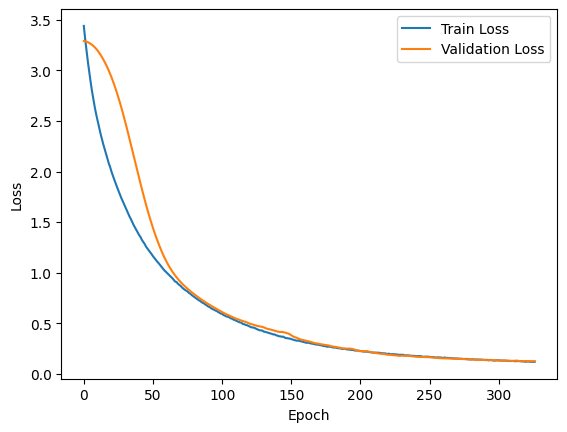

In [ ]:
import matplotlib.pyplot as plt

# After training loop
# Plotting training and validation loss
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
import cv2 
import mediapipe as mp
import torch
import joblib  # Assuming you saved the scaler using joblib
import torch.nn as nn
import torch.nn.functional as F  # Correct import

class EnhancedHandGestureModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(63, 128)  # Adjust input size (63) for hand coordinates
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(64, 27)  # Output layer for 27 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop1(x)  # Dropout for regularization
        x = self.relu(self.bn2(self.fc2(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop2(x)  # Dropout for regularization
        x = self.fc3(x)  # Output logits for 27 classes
        return x  # No Softmax required for CrossEntropyLoss

# Initialize the model
model = EnhancedHandGestureModel()

# Load the state dictionary (the saved model weights)
state_dict = torch.load("best_model.pth")

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.eval()

# Load the scaler
scaler = joblib.load("scaler.pkl")  # Adjust path as necessary

# Define the mapping for 27 classes
class_map = ['Blank'] + [chr(i) for i in range(ord('A'), ord('Z')+1)]  # Blank + A-Z

def map_class_to_letter(predicted_class):
    """ Map the predicted class index to a letter or blank """
    return class_map[predicted_class]

def predict_gesture(landmarks):
    """ Normalize landmarks and run prediction with the model """
    # Convert landmarks into a 63-dimensional vector (flattened)
    hand_coords = []
    for lm in landmarks:
        hand_coords.append(lm.x)
        hand_coords.append(lm.y)
        hand_coords.append(lm.z)

    # Convert to a 2D array and apply scaling
    hand_coords = [hand_coords]  # Convert to 2D array with shape (1, 63)
    hand_coords = scaler.transform(hand_coords)  # Normalize the coordinates
    
    # Convert to a torch tensor
    input_tensor = torch.tensor(hand_coords, dtype=torch.float32)  # Add batch dimension
    
    # Get model output
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)  # Get predicted class
    return predicted.item()  # Return the predicted class

# Mediapipe intialisation
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0)

with mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()

        if not success:
            break
        # Convert the image to RGB (MediaPipe works with RGB images)
        image.flags.writeable =True
        result = hands.process(image)
        if result.multi_hand_world_landmarks:
            for landmarks in result.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(image, landmarks, mp_hands.HAND_CONNECTIONS)

            for landmarks in result.multi_hand_world_landmarks:
                # # Extract landmarks and make predictions
                predicted_class = predict_gesture(landmarks.landmark)
                # Map predicted class index to gesture label
                predicted_gesture = map_class_to_letter(predicted_class)

                # Display the predicted gesture on the frame
                cv2.putText(image, f"Gesture: {predicted_gesture}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('mediapipe', image)
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


# NEED TO WORK ON T, Q, S, F
# COULD DO MORE ON G M A


In [2]:
import mediapipe as mp
import cv2

# Mediapipe intialisation
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0)

with mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()

        if not success:
            break
        # Convert the image to RGB (MediaPipe works with RGB images)
        # Copy frame to draw for display
        display_frame = image.copy()
        image.flags.writeable =True
        result = hands.process(image)
        if result.multi_hand_world_landmarks:
            for landmarks in result.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(image, landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow('mediapipe', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            for i in range(10):
                cv2.imwrite(f"data/R/{309+i}.jpg", display_frame)
            break

cap.release()
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
# Mediapipe initialization
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Load the image
image = cv2.imread("data/C/305.jpg")
if image is None:
    raise FileNotFoundError("Image not found at the specified path.")

# Convert the color from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image with MediaPipe Hands
with mp_hands.Hands(
        static_image_mode=True,
        model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
    
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_world_landmarks:
            mp_drawing.draw_landmarks(
                image,  # use original BGR image for drawing
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)
            print(hand_landmarks)

# Show the result
cv2.imshow('MediaPipe Hands', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

landmark {
  x: 0.0210611913
  y: 0.0925922692
  z: -0.0140211619
}
landmark {
  x: -0.00984112266
  y: 0.073064588
  z: -0.00191954069
}
landmark {
  x: -0.0317094587
  y: 0.0552287437
  z: 0.0108076176
}
landmark {
  x: -0.0563330203
  y: 0.0342240632
  z: 0.0316403471
}
landmark {
  x: -0.0746017694
  y: 0.0107971448
  z: 0.0500658378
}
landmark {
  x: -0.0217728
  y: 0.00437887665
  z: 0.0216831099
}
landmark {
  x: -0.0296516735
  y: -0.0222647227
  z: 0.0172031652
}
landmark {
  x: -0.0452664942
  y: -0.0349306799
  z: 0.00659386
}
landmark {
  x: -0.0641068667
  y: -0.0298515614
  z: -0.0178254414
}
landmark {
  x: -0.00316147157
  y: -0.0026683202
  z: 0.00897739455
}
landmark {
  x: -0.0177025404
  y: -0.0352816954
  z: -0.00505726691
}
landmark {
  x: -0.0404266976
  y: -0.0371542089
  z: -0.02554317
}
landmark {
  x: -0.0580727905
  y: -0.0299903788
  z: -0.0429496616
}
landmark {
  x: 0.013410436
  y: -0.00490094814
  z: -0.0142879728
}
landmark {
  x: -0.002234685
  y: -0.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# Canvas for drawing
canvas = np.zeros((720, 1280, 3), dtype=np.uint8)

# Capture webcam
cap = cv2.VideoCapture(0)

prev_x, prev_y = None, None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = hands.process(rgb_frame)
    canvas = cv2.resize(canvas, (w, h))

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            index_tip = hand_landmarks.landmark[8]
            thumb_tip = hand_landmarks.landmark[4]

            x = int(index_tip.x * w)
            y = int(index_tip.y * h)
            thumb_x = int(thumb_tip.x * w)
            thumb_y = int(thumb_tip.y * h)

            distance = np.hypot(thumb_x - x, thumb_y - y)

            if prev_x is None:
                prev_x, prev_y = x, y

            # ✅ Draw only if thumb and index are pinched
            if distance < 25:
                cv2.line(canvas, (prev_x, prev_y), (x, y), (255, 0, 255), 5)
                prev_x, prev_y = x, y
            else:
                prev_x, prev_y = None, None

            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    else:
        prev_x, prev_y = None, None

    # 🔁 Check for keypresses
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC to quit
        break
    elif key == ord('c'):  # 'c' to clear canvas
        canvas = np.zeros((h, w, 3), dtype=np.uint8)

    # Merge canvas with frame
    frame = cv2.addWeighted(frame, 1, canvas, 0.5, 0)

    cv2.imshow("Air Drawing", frame)


: 